In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from typing import Union,Sequence
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [46]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.60])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [47]:
# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [48]:
def ssim(x: np.ndarray, y: np.ndarray, maxval: np.ndarray = None) -> float:
    """Computes Structural Similarity Index Measure (SSIM).

    Parameters
    ----------
    x : np.ndarray
        Target image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D images,
        the first dimension should be 1.
    y : np.ndarray
        Predicted image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D
        images, the first dimension should be 1.
    maxval : np.ndarray
        Maximum value of the images. If None, it is computed from the images. If the images are normalized, maxval
        should be 1.

    Returns
    -------
    float
        Structural Similarity Index Measure.

    Examples
    --------
    >>> from atommic.collections.reconstruction.metrics.reconstruction_metrics import ssim
    >>> import numpy as np
    >>> datax = np.random.rand(3, 100, 100)
    >>> datay = datax * 0.5
    >>> ssim(datax, datay)
    0.01833040155119426

    .. note::
        x and y must be normalized to the same range, e.g. [0, 1].

        The SSIM is computed using the scikit-image implementation of the SSIM metric.
        Source: https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity
    """
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match prediction dimensions.")

    maxval = max(np.max(x) - np.min(x), np.max(y) - np.min(y)) if maxval is None else maxval
    maxval = max(maxval, 1)
    ssim_score = sum(
        structural_similarity(x[slice_num], y[slice_num], data_range=maxval) for slice_num in range(x.shape[0])
    )
    return ssim_score / x.shape[0]

In [49]:
def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x**2).sum(dim=-1)

In [50]:
def check_stacked_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Check if tensor is stacked complex (real & imaginary parts stacked along last dim) and convert it to a combined
    complex tensor.

    Parameters
    ----------
    x : torch.Tensor
        Tensor to check.

    Returns
    -------
    torch.Tensor
        Tensor with stacked complex converted to combined complex.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import check_stacked_complex
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> data = torch.view_as_real(data)
    >>> data.shape
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    """
    return torch.view_as_complex(x) if x.shape[-1] == 2 else x

In [52]:

fname = '/scratch/tmpaquaij/Results/atommic/mltrs/trained_models/SKMTEA_small/MTLRS_SENSE/predictions_4x/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    scan = torch.from_numpy(f['reconstruction'][()].squeeze())
    predictions = f['segmentation'][()].squeeze()
    target = torch.from_numpy(f['target_reconstruction'][()].squeeze())
    segmentation_labels = f['target_segmentation'][()].squeeze()
#segmentation_labels = nib.load(fsegname).get_fdata()
print(predictions.shape,segmentation_labels.shape,target.shape)

(74, 4, 208, 256) (74, 4, 208, 256) torch.Size([74, 208, 256])


In [53]:
predictions = np.abs(predictions.astype(np.float32))
predictions = np.where(predictions > 0.5, 1, 0)

segmentation_labels = np.abs(segmentation_labels.astype(np.float32))
segmentation_labels = np.where(segmentation_labels > 0.5, 1, 0)

print(predictions.shape,segmentation_labels.shape)

(74, 4, 208, 256) (74, 4, 208, 256)


In [54]:
print(target)

tensor([[[ 9.6902e-05-1.1004e-03j,  1.9167e-03-1.3175e-03j,
          -9.6617e-04-1.3303e-03j,  ...,
           9.8752e-05-4.3368e-04j, -7.8301e-04-2.3343e-03j,
          -3.3170e-04+5.2907e-04j],
         [-2.2164e-03+5.4079e-04j,  6.9798e-04-4.1081e-03j,
          -3.2174e-04-1.8222e-03j,  ...,
          -1.5480e-03-6.7401e-04j, -3.0183e-03-1.0212e-03j,
          -7.0464e-04-2.9688e-03j],
         [ 9.8387e-03+8.5942e-03j,  2.6570e-03+2.5981e-03j,
          -6.5201e-03+3.2834e-03j,  ...,
           2.9742e-03-1.3036e-03j,  7.7792e-03+1.2025e-03j,
          -1.4227e-03-3.6603e-03j],
         ...,
         [-2.8059e-03-5.5602e-03j,  2.7931e-04-4.0707e-03j,
          -2.4252e-03+7.0443e-03j,  ...,
          -2.7925e-04-2.2788e-03j, -3.6212e-03-5.1914e-03j,
           8.9100e-04+2.2493e-04j],
         [-1.9252e-03-6.0495e-03j,  1.9431e-03-4.2792e-03j,
          -1.2546e-03+3.0163e-04j,  ...,
          -1.7032e-03-4.2801e-03j,  3.8102e-03-5.2009e-03j,
           5.3270e-03-5.5051e-03j],
 

In [55]:
# Current loss determination
print(type(target))
scan_split = torch.view_as_real(scan).numpy()
target_split = torch.view_as_real(target).numpy()
target_norm = target_split/np.max(np.abs(target_split))
scan_norm = scan_split/np.max(np.abs(scan_split))
print(np.max(target_norm[...,0]),np.max(target_norm[...,1]),np.min(target_norm[...,0]),np.min(target_norm[...,1]))


target_stacked = check_stacked_complex(torch.from_numpy(target_norm))
scan_stacked = check_stacked_complex(torch.from_numpy(scan_norm))


target_stacked_abs = torch.abs(target_stacked / torch.max(torch.abs(target_stacked))).numpy()
scan_stacked_abs = torch.abs(scan_stacked / torch.max(torch.abs(scan_stacked))).numpy()

target_stacked_angle= torch.imag(target_stacked / torch.max(torch.abs(target_stacked))).numpy()
scan_stacked_angle = torch.imag(scan_stacked / torch.max(torch.abs(scan_stacked))).numpy()

max_value = max(np.max(target_stacked_abs)-np.min(target_stacked_abs), np.max(scan_stacked_abs)-np.min(scan_stacked_abs))
score = ssim(target_stacked_abs,scan_stacked_abs,maxval=max_value)


#angle is not implemented why?
max_value = max(np.max(target_stacked_angle)-np.min(target_stacked_angle), np.max(scan_stacked_angle)-np.min(scan_stacked_angle))
score = ssim(target_stacked_angle,scan_stacked_angle,maxval=max_value)
print(score)
print(np.max(target_stacked_abs),np.max(target_stacked_abs),np.min(target_stacked_abs),np.min(target_stacked_abs))
print(np.max(target_stacked_angle),np.max(target_stacked_angle),np.min(target_stacked_angle),np.min(target_stacked_angle))

<class 'torch.Tensor'>
1.0 0.77172554 -0.7019864 -0.8817024
0.675025367929227
0.99999994 0.99999994 1.3134818e-06 1.3134818e-06
0.7717129 0.7717129 -0.88168806 -0.88168806


array([<Axes: title={'center': 'Predicted_angle'}>,
       <Axes: title={'center': 'Target_angle'}>], dtype=object)

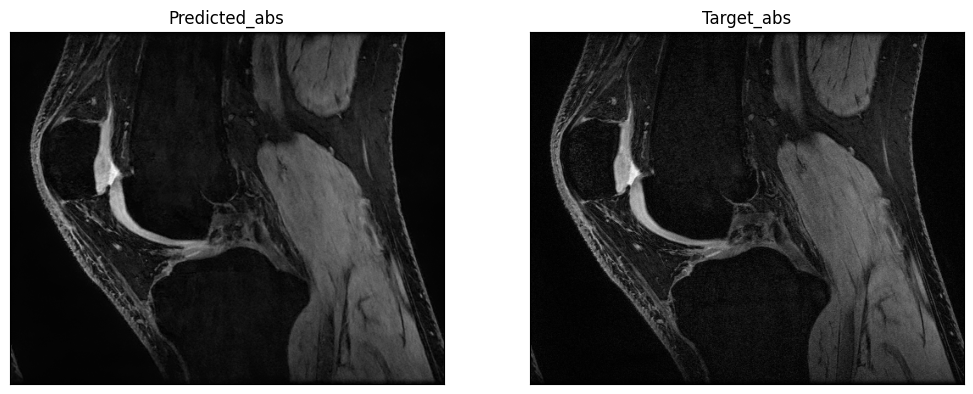

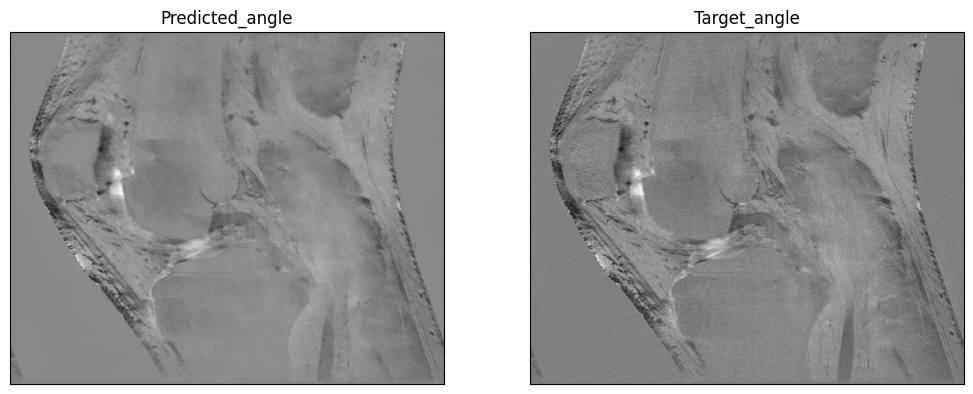

In [27]:
sl = 40
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl, :, :, :], channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl, :, :, :], channel_dim=0), bg_label=0)
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_stacked_abs[sl], target_stacked_abs[sl]], titles=['Predicted_abs', 'Target_abs'], fontsize=12, wsize=wsize, hsize=hsize)
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_stacked_angle[sl], target_stacked_angle[sl]], titles=['Predicted_angle', 'Target_angle'], fontsize=12, wsize=wsize,
            hsize=hsize)

In [28]:
#Current metric determination
print(target.shape,scan.shape)
if torch.is_complex(target) and target.shape[-1] != 2:
    target_split = torch.view_as_real(target)
    target_split = complex_abs(target_split)
if target.shape[-1] == 2:
    target_split = complex_abs(target)
target_norm = (target_split / torch.max(
    torch.abs(target_split)
)).numpy()

if (
    torch.is_complex(scan)
    and scan.shape[-1] != 2
):
    scan_split = torch.view_as_real(scan)
    scan_split = complex_abs(scan_split)
if scan.shape[-1] == 2:
    scan_split = complex_abs(scan)
scan_norm = (scan_split / torch.max(
    torch.abs(scan_split)
)).numpy()
print(target_norm.shape,scan_norm.shape)
max_value = max(np.max(target_norm)-np.min(target_norm), np.max(scan_norm)-np.min(scan_norm))
score = ssim(scan_norm,target_norm,maxval=max_value)
print(score)

torch.Size([80, 416, 512]) torch.Size([80, 416, 512])
(80, 416, 512) (80, 416, 512)
0.8046549596021754


array([<Axes: title={'center': 'Predicted_abs'}>,
       <Axes: title={'center': 'Target_abs'}>], dtype=object)

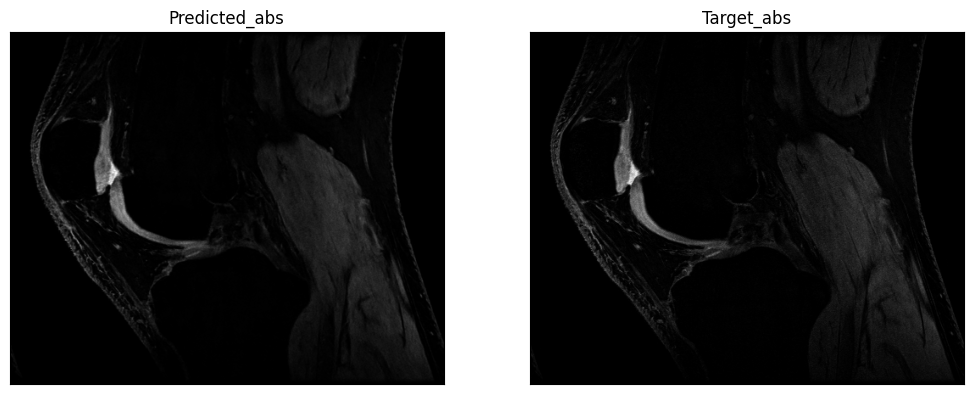

In [29]:

sl = 40
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl, :, :, :], channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl, :, :, :], channel_dim=0), bg_label=0)
scan_abs = scan_norm[sl]
target_abs = target_norm[sl]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_abs, target_abs], titles=['Predicted_abs', 'Target_abs'], fontsize=12, wsize=wsize, hsize=hsize)

In [13]:
target_split = torch.view_as_real(target).numpy()
scan_split = torch.view_as_real(scan).numpy()

target_norm = np.zeros((target_split.shape))
scan_norm = np.zeros((target_split.shape))
score=0
for i in range(target_split.shape[-1]):
    target_norm[...,i] = target_split[...,i]/np.max(np.abs(target_split[...,i]))
    scan_norm[...,i] = scan_split[...,i]/np.max(np.abs(scan_split[...,i]))
    max_value = max(np.max(target_norm[...,i])-np.min(target_norm[...,i]), np.max(scan_norm[...,i])-np.min(scan_norm[...,i]))
    score_i  =ssim(scan_norm[...,i],target_norm[...,i],maxval=max_value)
    print(score_i)
    score +=score_i
    print(score)
score_def =score/2
print(score_def)


0.833174484223529
0.833174484223529
0.708485063660143
1.5416595478836719
0.7708297739418359


In [14]:
print(np.max(target_norm[...,0]),np.max(target_norm[...,0]),np.min(target_norm[...,1]),np.min(target_norm[...,1]))
target_def = torch.view_as_complex(torch.from_numpy(target_norm))
scan_def = torch.view_as_complex(torch.from_numpy(scan_norm))

1.0 1.0 -1.0 -1.0


array([<Axes: title={'center': 'Predicted_angle'}>,
       <Axes: title={'center': 'Target_angle'}>], dtype=object)

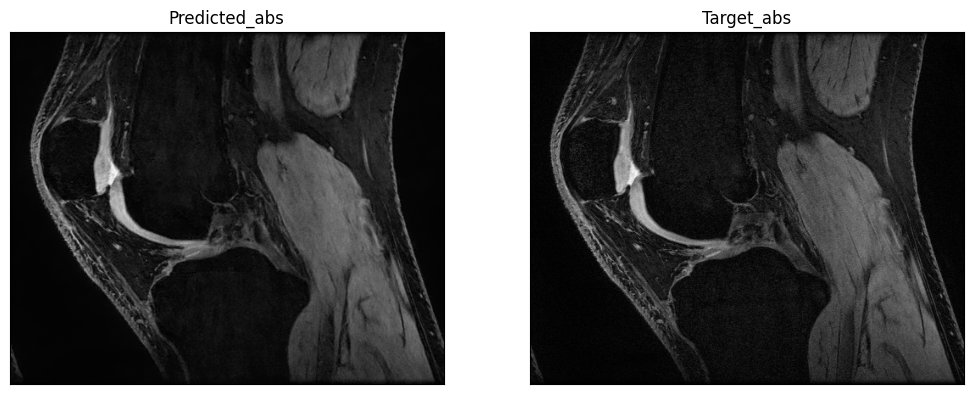

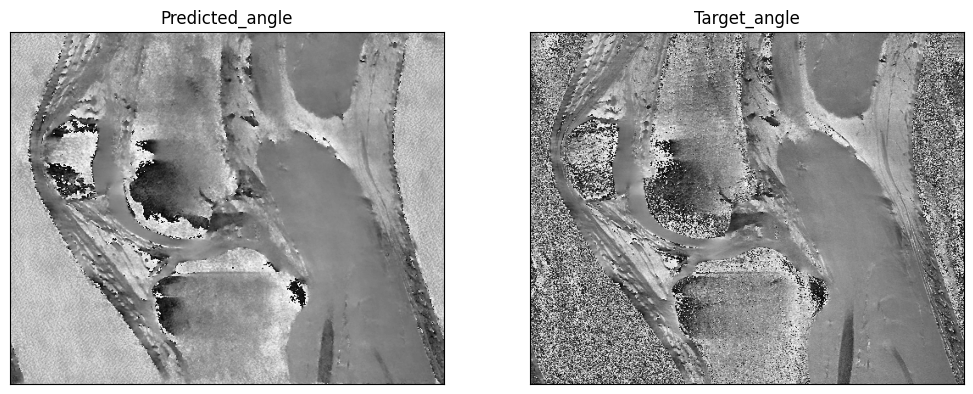

In [15]:
sl=40
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl,:,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_abs = torch.abs(scan_def)[sl]
target_abs = torch.abs(target_def[sl])
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_abs,target_abs],titles=['Predicted_abs','Target_abs'],fontsize =12,wsize=wsize,hsize=hsize)
scan_angle= torch.angle(scan_def)[sl]
target_angle = torch.angle(target_def[sl])
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_angle,target_angle],titles=['Predicted_angle','Target_angle'],fontsize =12,wsize=wsize,hsize=hsize)

In [ ]:
sl=30
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl,:,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_plt = scan[sl]
target_plt = target[sl]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_plt,target_plt],titles=['Predicted','Target'],fontsize =12,wsize=wsize,hsize=hsize)
plt.savefig(f'/scratch/tmpaquaij/Figures/validate_segmentation_slice_{sl}_{fname.rsplit("/", maxsplit=1)[-1].replace(".h5","")}.png')

In [ ]:
sl=50
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl,:,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_plt = scan[sl]
target_plt = target[sl]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_plt,target_plt],titles=['Predicted','Target'],fontsize =12,wsize=wsize,hsize=hsize)
plt.savefig(f'/scratch/tmpaquaij/Figures/validate_segmentation_slice_{sl}_{fname.rsplit("/", maxsplit=1)[-1].replace(".h5","")}.png')

In [ ]:
ssl=30
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl,:,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_plt = scan[sl]
target_plt = target[sl]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_plt,target_plt],titles=['Predicted','Target'],fontsize =12,wsize=wsize,hsize=hsize)
plt.savefig(f'/scratch/tmpaquaij/Figures/validate_segmentation_slice_{sl}_{fname.rsplit("/", maxsplit=1)[-1].replace(".h5","")}.png')

In [99]:
fname = '/scratch/tmpaquaij/Results/atommic/mltrs/trained_models/SKMTEA/MTLRS_SENSE/predictions_4x/2024-01-07_11-56-42/checkpoints/default--val_loss=0.0095-epoch=50-last/predictions/MTR_080.h5'
with h5py.File(fname, "r") as f:
    scan = torch.from_numpy(f['reconstruction'][()].squeeze())
    predictions = f['segmentation'][()].squeeze()
    target = torch.from_numpy(f['target_reconstruction'][()].squeeze())
    segmentation_labels = f['target_segmentation'][()].squeeze()
    variance = f['uncertainty'][()].squeeze()
#segmentation_labels = nib.load(fsegname).get_fdata()
predictions = np.abs(predictions.astype(np.float32))
predictions = np.where(predictions > 0.5, 1, 0)

segmentation_labels = np.abs(segmentation_labels.astype(np.float32))
segmentation_labels = np.where(segmentation_labels > 0.5, 1, 0)
print(predictions.shape,segmentation_labels.shape,target.shape,variance.shape)

(74, 4, 416, 512) (74, 4, 416, 512) torch.Size([74, 416, 512]) (74, 5, 416, 512)


In [100]:
# Current loss determination
sl=19
target_norm = np.abs(target.numpy()/np.max(np.abs(target.numpy())))
scan_norm = np.abs(scan.numpy()/np.max(np.abs(scan.numpy())))



print(np.max(target_norm),np.min(target_norm))
max_value = max(np.max(target_norm[sl])-np.min(target_norm[sl]), np.max(scan_norm[sl])-np.min(scan_norm[sl]))
score = ssim(target_norm[sl],scan_norm[sl],maxval=max_value)
print(score)

0.99999994 2.686486e-06
0.7560511184015385


In [105]:
sl=21
c = 4
predictions_plt = label2rgb(one_hot_to_categorical(predictions[:,sl,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_plt = scan_norm[sl,:,:]
target_plt = target_norm[sl,:,:]
variance_plt = variance[sl,c,...]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_plt,target_plt,variance_plt],titles=['Predicted','Target',f'Uncertainty_cascade_{c+1}'],fontsize =12,wsize=wsize,hsize=hsize,overlay=[predictions_plt,segmentation_labels_plt,None],cmap=['gray','gray','viridis'])
plt.savefig(f'/scratch/tmpaquaij/Figures/validate_segmentation_slice_{sl}_{fname.rsplit("/", maxsplit=1)[-1].replace(".h5","")}.png')

IndexError: index 21 is out of bounds for axis 1 with size 4

In [78]:


scan_split = torch.view_as_real(scan).numpy()
target_split = torch.view_as_real(target).numpy()
target_abs_sq= complex_abs(torch.from_numpy(target_split)).numpy()
scan_abs_sq= complex_abs(torch.from_numpy(scan_split)).numpy()
print(np.max(target_abs_sq),np.min(target_abs_sq))

target_norm = np.sqrt(target_abs_sq/np.max(np.abs(target_abs_sq)))
scan_norm = np.sqrt(scan_abs_sq/np.max(np.abs(scan_abs_sq)))

print(np.max(target_norm),np.min(target_norm))
max_value = max(np.max(target_norm)-np.min(target_norm), np.max(scan_norm)-np.min(scan_norm))
score = ssim(target_norm,scan_norm,maxval=1)
print(score)

1.0002966 6.7387757e-13
1.0 8.207787e-07
0.7338050741919215


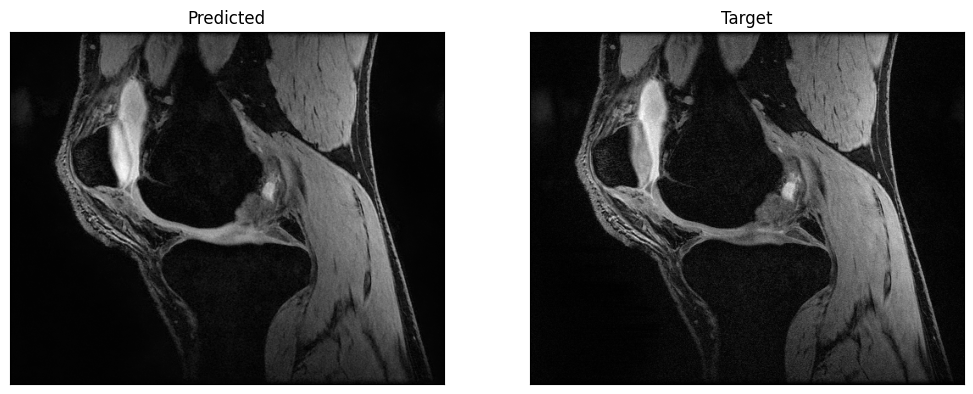

In [87]:
sl=30
predictions_plt = label2rgb(one_hot_to_categorical(predictions[sl,:,:,:],channel_dim=0), bg_label=0)
segmentation_labels_plt = label2rgb(one_hot_to_categorical(segmentation_labels[sl,:,:,:],channel_dim=0), bg_label=0)
scan_plt = scan_norm[sl]
target_plt = target_norm[sl]
hsize = 5
wsize = hsize / predictions_plt.shape[0] * predictions_plt.shape[1]
plot_images([scan_plt,target_plt],titles=['Predicted','Target'],fontsize =12,wsize=wsize,hsize=hsize)
plt.savefig(f'/scratch/tmpaquaij/Figures/validate_segmentation_slice_{sl}_{fname.rsplit("/", maxsplit=1)[-1].replace(".h5","")}.png')

In [88]:

target_mag = np.abs(target.numpy()/np.max(np.abs(target.numpy())))
scan_mag = np.abs(scan.numpy()/np.max(np.abs(scan.numpy())))
print(np.max(target_mag),np.max(scan_mag))

0.99999994 1.0
